# Thermal behavior of a wall

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [3]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
# download('https://raw.githubusercontent.com/AllenDowney/' +
        #  'ModSimPy/master/modsim.py')

In [1]:
# import functions from modsim

from modsim import *

This case study is based on Gori, Marincioni, Biddulph, Elwell, "Inferring the thermal resistance and effective thermal mass distribution of a wall from in situ measurements to characterise heat transfer at both the interior and exterior surfaces", *Energy and Buildings*, Volume 135, 15 January 2017, Pages 398-409, [which I downloaded here](https://www.sciencedirect.com/science/article/pii/S0378778816313056).
    
The authors put their paper under a Creative Commons license, and [make their data available here](http://discovery.ucl.ac.uk/1526521).  I thank them for their commitment to open, reproducible science, which made this case study possible.

The goal of their paper is to model the thermal behavior of a wall as a step toward understanding the "performance gap between the expected energy use of buildings and their measured energy use".  The wall they study is identified as the exterior wall of an office building in central London, [not unlike this one](https://www.google.com/maps/@51.5269375,-0.1303666,3a,75y,90h,88.17t/data=!3m6!1e1!3m4!1sAoAXzN0mbGF9acaVEgUdDA!2e0!7i13312!8i6656).

The following figure shows the scenario and their model:

![Figure 2](https://ars.els-cdn.com/content/image/1-s2.0-S0378778816313056-gr2.jpg)

On the interior and exterior surfaces of the wall, they measure temperature and heat flux over a period of three days.  They model the wall using two thermal masses connected to the surfaces, and to each other, by thermal resistors.

The primary methodology of the paper is a Bayesian method for inferring the parameters of the system (two thermal masses and three thermal resistances).

The primary result is a comparison of two models: the one shown here with two thermal masses, and a simpler model with only one thermal mass.  They find that the two-mass model is able to reproduce the measured fluxes substantially better.

Tempting as it is, I will not replicate their method for estimating the parameters.  Rather, I will implement their model and run it with their estimated parameters.

The following cells download and read the data.

In [5]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/data/DataOWall.csv')

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

In [6]:
data = pd.read_csv('DataOWall.csv', 
                   parse_dates=[0], index_col=0, 
                   header=0, skiprows=[1,2])
data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


The index contains Pandas `Timestamp` objects, which is good for dealing with real-world dates and times, but not as good for running the simulations, so I'm going to convert to seconds.

In [7]:
timestamp_0 = data.index[0]
timestamp_0

Timestamp('2014-10-05 16:30:00')

Subtracting the first `Timestamp` yields `Timedelta` objects:

In [8]:
time_deltas = data.index - timestamp_0
time_deltas.dtype

dtype('<m8[ns]')

Then we can convert to seconds and replace the index.

In [9]:
data.index = time_deltas.days * 86400 + time_deltas.seconds
data.head()

,Q_in,Q_out,T_int,T_ext
0,10.994,6.840,16.92,14.68
300,10.952,6.012,16.92,14.69
600,10.882,7.040,16.93,14.66
900,10.798,8.880,16.93,14.59
1200,10.756,10.491,16.94,14.50


The timesteps are all 5 minutes:

In [10]:
np.all(np.diff(data.index) == 300)

np.True_

Plot the measured fluxes.

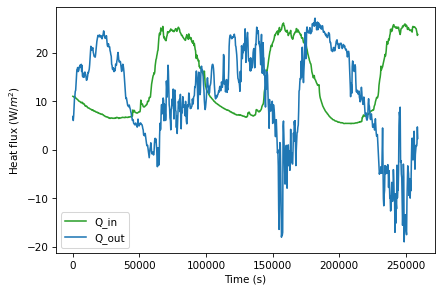

In [12]:
data.Q_in.plot(color='C2', label='Q_in')
data.Q_out.plot(color='C0', label='Q_out')
decorate(xlabel='Time (s)',
         ylabel='Heat flux (W/$m^2$)')

Plot the measured temperatures.

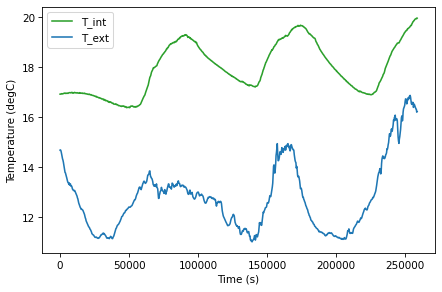

In [13]:
data.T_int.plot(color='C2', label='T_int')
data.T_ext.plot(color='C0', label='T_ext')
decorate(xlabel='Time (s)',
         ylabel='Temperature (degC)')

## Making the System object

`params` is a sequence with the [estimated parameters from the paper](https://www.sciencedirect.com/science/article/pii/S0378778816313056#tbl0005).

In [14]:
R1 = 0.076   # m**2 * K / W,
R2 = 0.272   # m**2 * K / W,
R3 = 0.078   # m**2 * K / W,
C1 = 212900  # J / m**2 / K,
C2 = 113100  # J / m**2 / K

In [15]:
params = R1, R2, R3, C1, C2

We'll pass `params` to `make_system`, which computes `init`, packs the parameters into `Series` objects, and computes the interpolation functions.

In [17]:
def make_system(params, data):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    R1, R2, R3, C1, C2 = params
    
    init = State(T_C1 = 16.11, T_C2 = 15.27)
    
    t_end = data.index[-1]
    
    return System(init=init,
                  R=(R1, R2, R3),
                  C=(C1, C2),
                  T_int_func=interpolate(data.T_int),
                  T_ext_func=interpolate(data.T_ext),
                  t_end=t_end)

Make a `System` object

In [18]:
system = make_system(params, data)
system

namespace(init=T_C1    16.11
               T_C2    15.27
               Name: state, dtype: float64,
          R=(0.076, 0.272, 0.078),
          C=(212900, 113100),
          T_int_func=<scipy.interpolate._interpolate.interp1d at 0x12cd924e0>,
          T_ext_func=<scipy.interpolate._interpolate.interp1d at 0x12cd928a0>,
          t_end=np.int64(258900))

Test the interpolation function:

In [19]:
system.T_ext_func(0), system.T_ext_func(150), system.T_ext_func(300)

(array(14.68), array(14.685), array(14.69))

## Implementing the model

Next we need a slope function that takes instantaneous values of the two internal temperatures and computes their time rates of change.

The slope function gets called two ways.

* When we call it directly, `state` is a `State` object and the values it contains have units.

* When `run_solve_ivp` calls it, `state` is an array and the values it contains don't have units.

In the second case, we have to apply the units before attempting the computation.  `require_units` applies units if necessary:

The following function computes the fluxes between the four zones.

In [20]:
def compute_flux(t, state, system):
    """Compute the fluxes between the walls surfaces and the internal masses.
    
    state: State with T_C1 and T_C2
    t: time in seconds
    system: System with interpolated measurements and the R Series
    
    returns: Series of fluxes
    """    
    # unpack the temperatures
    T_C1, T_C2 = state
        
    # compute a series of temperatures from inside out
    T_int = system.T_int_func(t)
    T_ext = system.T_ext_func(t)
    
    T = [T_int, T_C1, T_C2, T_ext]
    
    # compute differences of adjacent temperatures
    T_diff = np.diff(T)

    # compute fluxes between adjacent compartments
    Q = T_diff / system.R
    return Q

We can test it like this.

In [21]:
compute_flux(0, system.init, system)

array([-10.65789474,  -3.08823529,  -7.56410256])

Here's a slope function that computes derivatives of `T_C1` and `T_C2`

In [22]:
def slope_func(t, state, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    Q = compute_flux(t, state, system)

    # compute the net flux in each node
    Q_diff = np.diff(Q)
        
    # compute the rate of change of temperature
    dQdt = Q_diff / system.C
    return dQdt

Test the slope function with the initial conditions.

In [23]:
slopes = slope_func(0, system.init, system)
slopes

array([ 3.55549997e-05, -3.95744233e-05])

Now let's run the simulation, generating estimates for the time steps in the data.

In [24]:
results, details = run_solve_ivp(system, slope_func,
                                 t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Here's what the results look like.

In [25]:
results.head()

,T_C1,T_C2
0,16.110000,15.270000
300,16.120516,15.258636
600,16.130820,15.247580
900,16.140992,15.235209
1200,16.150975,15.220746


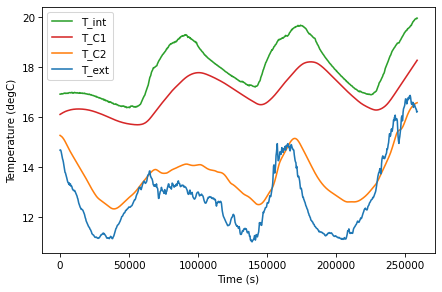

In [26]:
def plot_results(results, data):
    data.T_int.plot(color='C2')
    results.T_C1.plot(color='C3')
    results.T_C2.plot(color='C1')
    data.T_ext.plot(color='C0')
    decorate(xlabel='Time (s)',
             ylabel='Temperature (degC)')
    
plot_results(results, data)

These results are similar to what's in the paper:

![Figure 5](https://ars.els-cdn.com/content/image/1-s2.0-S0378778816313056-gr5.jpg).  

To get the estimated fluxes, we have to go through the results and basically do the flux calculation again.

In [27]:
def recompute_fluxes(results, system):
    """Compute fluxes between wall surfaces and internal masses.
    
    results: Timeframe with T_C1 and T_C2
    system: System object
    
    returns: Timeframe with Q_in and Q_out
    """
    Q_frame = TimeFrame(index=results.index, 
                        columns=['Q_in', 'Q_out'])
    
    for t, row in results.iterrows():
        Q = compute_flux(t, row, system)
        Q_frame.loc[t] = (-Q[0], -Q[2])
        
    return Q_frame

In [28]:
Q_frame = recompute_fluxes(results, system)
Q_frame.head()

,Q_in,Q_out
0,10.657895,7.564103
300,10.519523,7.290204
600,10.515533,7.533080
900,10.381690,8.271905
1200,10.381907,9.240336


Let's see how the estimates compare to the data.

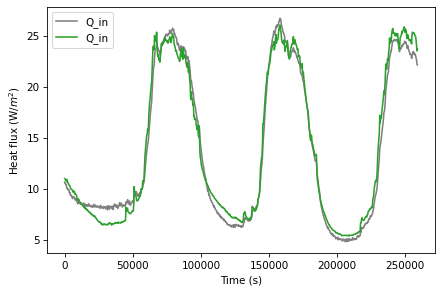

In [29]:
def plot_Q_in(frame, data):
    frame.Q_in.plot(color='gray')
    data.Q_in.plot(color='C2')
    decorate(xlabel='Time (s)',
             ylabel='Heat flux (W/$m^2$)')
    
plot_Q_in(Q_frame, data)

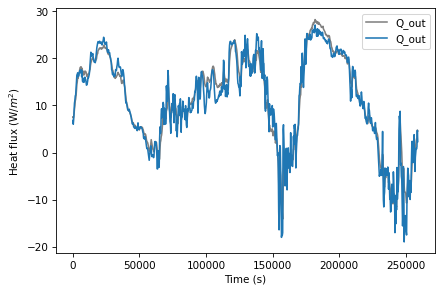

In [30]:
def plot_Q_out(frame, data):
    frame.Q_out.plot(color='gray')
    data.Q_out.plot(color='C0')
    decorate(xlabel='Time (s)',
             ylabel='Heat flux (W/$m^2$)')
    
plot_Q_out(Q_frame, data)

These results are also similar to what's in the paper (the bottom row):

![Figure 3](https://ars.els-cdn.com/content/image/1-s2.0-S0378778816313056-gr3.jpg)